# LR for Personality Prediction

## 1. Raw data processing

In [73]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
plt.rcParams['axes.unicode_minus']=False 

In [74]:
data = []
with open('All_Beauty_5.json', 'r') as r:
    for line in r.readlines():
        data.append(json.loads(line.strip()))

In [75]:
data[0]

{'overall': 5.0,
 'verified': True,
 'reviewTime': '09 1, 2016',
 'reviewerID': 'A3CIUOJXQ5VDQ2',
 'asin': 'B0000530HU',
 'style': {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice Blue'},
 'reviewerName': 'Shelly F',
 'reviewText': 'As advertised. Reasonably priced',
 'summary': 'Five Stars',
 'unixReviewTime': 1472688000}

In [76]:
# analyse how many users
users = set()
for d in data:
    users.add(d['reviewerID'])
    
user_action = {}
for meta in data:
    if 'reviewText' in meta.keys():
        try:
            user_action[meta['reviewerID']] += ' ' + meta['reviewText']
        except:
            user_action[meta['reviewerID']] = meta['reviewText']

In [77]:
scores = pd.read_csv('scores.csv')

per_list = ['field0', 'personality.agreeableness', 'personality.conscientiousness', 'personality.neuroticism', \
            'personality.extraversion', 'personality.openness']

df_score = scores[per_list]

df_score

,field0,personality.agreeableness,personality.conscientiousness,personality.neuroticism,personality.extraversion,personality.openness
0,A3CIUOJXQ5VDQ2,44.347317,28.418990,29.275841,39.493122,47.044458
1,A3H7T87S984REU,43.284159,30.120131,49.090500,44.788948,52.152907
2,A3J034YH7UG4KT,40.891697,32.660445,43.042456,32.509192,41.781220
3,A2UEO5XR3598GI,43.600214,48.913874,44.971834,38.407837,48.452678
4,A3SFRT223XXWF7,45.393149,48.234687,48.691462,53.320646,50.918121
...,...,...,...,...,...,...
985,A1210QJT54O8T0,67.843343,62.300669,45.770167,59.873719,51.591437
986,A2UEIN7SIPZFRP,64.129326,48.286311,40.899663,59.844976,52.869251
987,A3NFZN1GS1RKR9,54.747388,49.374668,35.771254,59.199041,46.393965
988,AUX122XW8ONG6,67.925456,64.702857,40.155536,62.045575,51.167200


In [78]:
user_action['A3CIUOJXQ5VDQ2']

'As advertised. Reasonably priced As advertised. Reasonably priced as advertised as advertised as advertised'

In [79]:
import gensim
from gensim.models import Word2Vec
import multiprocessing

corpus = []

for user in df_score['field0'].values:
    corpus.append(user_action[user].split(" "))

model = Word2Vec(corpus, window=8, size=300, min_count=1, sg=1, workers=multiprocessing.cpu_count(), seed=2021, iter=15)
model.save('lr_wv.model')

In [80]:
# get features
datas = []
for user in df_score['field0'].values:
    words = user_action[user].split(" ")
    total = [0] * 300
    for word in words:
        total += model.wv[word]
    total = total / len(words)
    datas.append(total)

# get label
cols = ['personality.agreeableness', 'personality.conscientiousness', 'personality.neuroticism', \
            'personality.extraversion', 'personality.openness']
labels = df_score[cols].idxmax(axis=1)

Y = [cols.index(y) for y in labels]

# get processed data
train_data = []
for i in range(0, len(Y)):
    train_data.append((datas[i], Y[i]))

In [81]:
import random
random.shuffle(train_data)
print(len(train_data))

990


## 2. Train/Test split

In [82]:
 #train, test = train_data[:890], train_data[890:]

# create a balanced test set
train, test = [], []
from collections import defaultdict

count_num = defaultdict(int)
for sample in train_data:
    label = sample[1]
    if count_num[label]<20:
        test.append(sample)
        count_num[label] += 1
    else:
        train.append(sample)
        
train_x, train_y, test_x, test_y = [], [], [], []
for t in train:
    train_x.append(t[0])
    train_y.append(t[1])
for t in test:
    test_x.append(t[0])
    test_y.append(t[1])

In [83]:
from collections import Counter
Counter(train_y), Counter (test_y)

(Counter({0: 628, 3: 113, 1: 57, 4: 52, 2: 40}),
 Counter({0: 20, 1: 20, 3: 20, 4: 20, 2: 20}))

## 3. Up Sampling

In [84]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.datasets import make_classification

In [85]:
print(len(train_x))
print(len(train_y))

from collections import Counter
print(Counter(train_y))
print(Counter(test_y))

890
890
Counter({0: 628, 3: 113, 1: 57, 4: 52, 2: 40})
Counter({0: 20, 1: 20, 3: 20, 4: 20, 2: 20})


In [86]:
oversample = RandomOverSampler(sampling_strategy='all')

train_x_over, train_y_over = oversample.fit_resample(train_x, train_y)

In [87]:
from collections import Counter
print(Counter(train_y_over))

Counter({0: 628, 3: 628, 1: 628, 4: 628, 2: 628})


## 4. Train LR model

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

classifier = LogisticRegression(C=1e5)

classifier.fit(train_x_over, train_y_over)

/Users/xinyuanlu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000.0)

In [89]:
y_predict = classifier.predict(test_x)

In [90]:
print(y_predict)
print(test_y)

[1 2 0 0 3 0 0 0 0 0 0 1 0 3 3 0 0 0 0 2 0 1 4 0 0 0 0 0 4 4 3 1 1 1 2 0 0
 1 1 1 0 0 3 0 2 3 1 0 0 2 2 2 3 0 3 4 3 0 3 0 0 0 0 3 0 2 3 2 2 4 1 1 0 4
 0 3 3 0 2 3 2 4 3 4 0 0 0 1 4 0 1 4 1 1 0 1 4 0 1 1]
[0, 1, 3, 0, 3, 0, 4, 0, 4, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 4, 0, 1, 3, 3, 2, 2, 1, 1, 4, 2, 1, 1, 2, 3, 3, 2, 3, 2, 3, 4, 3, 3, 3, 2, 1, 1, 2, 4, 1, 4, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 4, 1, 4, 4, 2, 4, 1, 1, 2, 2, 1, 2, 4, 1, 2, 4, 4, 4, 1, 4, 1, 1, 4, 2, 2, 2, 4, 4, 2, 2, 2]


In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_predict)
print(cm)

[[16  1  1  1  1]
 [ 7  5  1  7  0]
 [ 5  7  4  1  3]
 [ 6  3  6  5  0]
 [ 8  3  0  2  7]]


In [92]:
from sklearn.metrics import classification_report

target_names = ['AGR','CON','NEU','EXT','OPEN']
print(classification_report(test_y, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         AGR       0.38      0.80      0.52        20
         CON       0.26      0.25      0.26        20
         NEU       0.33      0.20      0.25        20
         EXT       0.31      0.25      0.28        20
        OPEN       0.64      0.35      0.45        20

    accuracy                           0.37       100
   macro avg       0.39      0.37      0.35       100
weighted avg       0.39      0.37      0.35       100



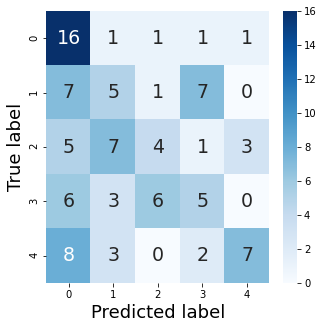

In [93]:
# create confusion matrix
conf_matrix = pd.DataFrame(cm, index = ['AGR','CON','NEU','EXT','OPEN'],columns=['AGR','CON','NEU','EXT','OPEN'])

# plot size setting
fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm, annot=True, annot_kws={"size": 19}, cmap="Blues")
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.show()